# Driver State Analysis

[https://dagshub.com/matejfric/driver-state](https://dagshub.com/matejfric/driver-state)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import os
import re
from pathlib import Path
from pprint import pprint

import albumentations as albu
import dagshub
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import pytorch_lightning as L
import torch

# Pytorch Lightning EarlyStopping callback does not recover the best weights as in Keras!
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# https://github.com/Lightning-AI/pytorch-lightning/discussions/10399,
# https://pytorch-lightning.readthedocs.io/en/1.5.10/extensions/generated/pytorch_lightning.callbacks.ModelCheckpoint.html
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from model import (
    SegmentationDatasetLoader,
    SegmentationDatasetSplit,
    SegmentationModel,
)
from model.augmentation import (
    compose_transforms,
    hard_transforms,
    post_transforms,
    pre_transforms,
    resize_transforms,
)
from model.git import get_commit_id, get_current_branch
from model.plot import (
    plot_learning_curves,
    plot_predictions,
    plot_predictions_compact,
    show_examples,
    show_random,
)

/home/lanter/source/driver-segmentation/segmentation-model/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


## Configuration

In [7]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14})

# Experiment logging
REPO_NAME = 'driver-state'
USER_NAME = 'matejfric'
dagshub.init(REPO_NAME, USER_NAME, mlflow=True)

# Reproducibility
# https://lightning.ai/docs/pytorch/stable/common/trainer.html#reproducibility
SEED = 42
L.seed_everything(SEED, workers=True)

print(
    f'torch: {torch.__version__}, cuda: {torch.cuda.is_available()}, lightning: {L.__version__}'
)

INFO:dagshub.auth.tokens:Removed expired tokens from the token cache


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

/home/lanter/source/driver-segmentation/segmentation-model/.venv/lib/python3.12/site-packages/rich/live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=fab9db0f-5e24-4af1-ad9d-1de48a34c503&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ca7a929aa35d77fea5af2137b15fe36928347ba36e1adf0a76b7c34bded158f6




gio: https://dagshub.com/login/oauth/authorize?state=fab9db0f-5e24-4af1-ad9d-1de48a34c503&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ca7a929aa35d77fea5af2137b15fe36928347ba36e1adf0a76b7c34bded158f6: Operation not supported


Accessing as matejfric

INFO:dagshub:Accessing as matejfric


Initialized MLflow to track repo "matejfric/driver-state"

INFO:dagshub:Initialized MLflow to track repo "matejfric/driver-state"


Repository matejfric/driver-state initialized!

INFO:dagshub:Repository matejfric/driver-state initialized!
INFO:lightning_fabric.utilities.seed:Seed set to 42


torch: 2.4.0+cu121, cuda: True, lightning: 2.2.4


In [8]:
# HYPERPARAMETERS
# ----------------------------------------
ENCODER = 'efficientnet-b0'  # 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'efficientnet-b1', 'mit_b1', ...
DECODER = 'unet'  # 'unet', 'unetplusplus', 'deeplabv3', 'deeplabv3plus', 'fpn', ...
FREEZE_ENCODER = True  # default True
MAX_EPOCHS = 100  # default 500
MONITOR = 'val_loss'
PATIENCE = 20  # default 
IMAGE_SIZE = 256  # default 
BATCH_SIZE = 32  # default 8
ENCODER_WEIGHTS = 'imagenet'  # 'imagenet' or None
LEARNING_RATE = 1e-4  # default 0.0001
AUGMENTATION = True  # default True

# LOGGING
# ----------------------------------------
LOG_DIR = Path('logs')
EXPERIMENT_NAME = f'{datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")}-{DECODER}-{ENCODER}'
VERSION = 0
EXPERIMENT_DIR = LOG_DIR / EXPERIMENT_NAME / f'version_{VERSION}'
DATASET_NAME = '2024-09-15-driver-segmentation-dataset'

MLFLOW_ARTIFACT_DIR = 'outputs'
METRICS_CSV_NAME = 'metrics.csv'
LEARNING_CURVES_PDF_NAME = 'learning_curves.pdf'
PREDICTIONS_PNG_NAME = 'predictions.png'
TRAIN_TRANSFORMS_JSON_NAME = 'train_transforms.json'

# DATASET
# ----------------------------------------
DATASET_DIR = Path(f'/home/lanter/source/driver-dataset/{DATASET_NAME}')

TRAIN_SET_DIR = 'train'
VALID_SET_DIR = 'validation'
TEST_SET_DIR = 'test'

IMAGES_DIR = 'images'
MASKS_DIR = 'masks'

TRAIN_IMAGES = sorted((DATASET_DIR / TRAIN_SET_DIR / IMAGES_DIR).glob('*.jpg'))
TRAIN_MASKS = sorted((DATASET_DIR / TRAIN_SET_DIR / MASKS_DIR).glob('*.png'))

VALID_IMAGES = sorted((DATASET_DIR / VALID_SET_DIR / IMAGES_DIR).glob('*.jpg'))
VALID_MASKS = sorted((DATASET_DIR / VALID_SET_DIR / MASKS_DIR).glob('*.png'))

TEST_IMAGES = sorted((DATASET_DIR / TEST_SET_DIR / IMAGES_DIR).glob('*.jpg'))
TEST_MASKS = sorted((DATASET_DIR / TEST_SET_DIR / MASKS_DIR).glob('*.png'))

In [9]:
# Exclude images from the training set
TRAIN_IMAGES = [img for img in TRAIN_IMAGES if 'stribny' not in img.stem]
TRAIN_MASKS = [mask for mask in TRAIN_MASKS if 'stribny' not in mask.stem]

In [ ]:
# show_random(TRAIN_IMAGES, TRAIN_MASKS)

In [ ]:
# show_random(VALID_IMAGES, VALID_MASKS)

In [ ]:
# show_random(TEST_IMAGES, TEST_MASKS)

## Augmentations and Transforms

In [10]:
if AUGMENTATION:
    train_transforms = compose_transforms(
        [
            pre_transforms(image_size=IMAGE_SIZE),
            hard_transforms(),
            post_transforms(),
        ]
    )
else:
    train_transforms = compose_transforms(
        [
            pre_transforms(image_size=IMAGE_SIZE),
            post_transforms(),
        ]
    )
valid_transforms = compose_transforms(
    [
        pre_transforms(image_size=IMAGE_SIZE),
        post_transforms(),
    ]
)
test_transforms = compose_transforms(
    [
        pre_transforms(image_size=IMAGE_SIZE),
        post_transforms(),
    ]
)

show_transforms = compose_transforms([pre_transforms(image_size=IMAGE_SIZE), hard_transforms()])

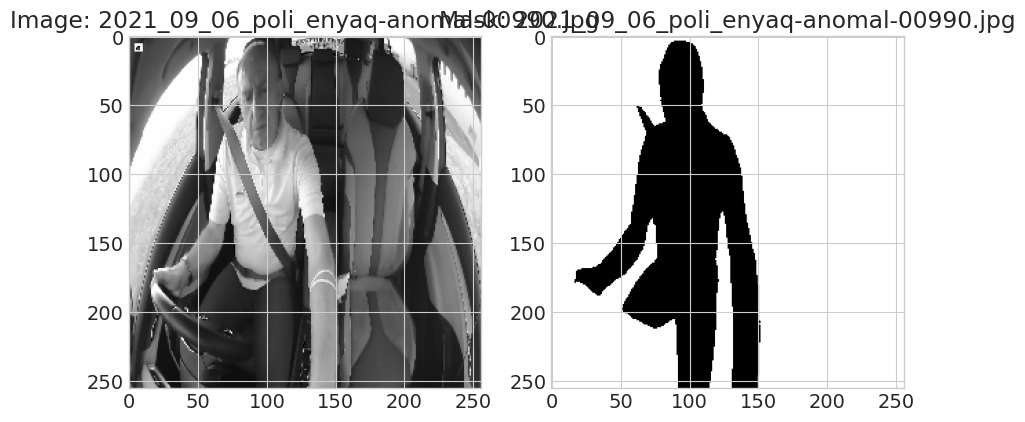

In [11]:
show_random(TRAIN_IMAGES, TRAIN_MASKS, transforms=show_transforms)

In [ ]:
# train_transforms.transforms

## Loaders

In [12]:
dataset_loader = SegmentationDatasetLoader(
    train=SegmentationDatasetSplit(images=TRAIN_IMAGES, masks=TRAIN_MASKS),
    valid=SegmentationDatasetSplit(images=VALID_IMAGES, masks=VALID_MASKS),
    test=SegmentationDatasetSplit(images=TEST_IMAGES, masks=TEST_MASKS),
)

INFO:root:Dataset paths validated successfully!
INFO:root:Shapes of images and masks validated successfully!


In [13]:
BATCH_SIZE_DICT = {'train': BATCH_SIZE, 'valid': BATCH_SIZE, 'test': BATCH_SIZE}
loaders = dataset_loader.get_loaders(
    # set to zero if RuntimeError: Trying to resize storage that is not resizable
    num_workers=int(os.cpu_count()),  # type: ignore
    batch_size=BATCH_SIZE_DICT,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    test_transforms=test_transforms,
)

train_dataloader = loaders['train']
valid_dataloader = loaders['valid']
test_dataloader = loaders['test']

## Training

In [14]:
model = SegmentationModel(
    DECODER,
    ENCODER,
    in_channels=3,
    out_classes=1,
    batch_size_dict=BATCH_SIZE_DICT,
    freeze_encoder=FREEZE_ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    learning_rate=LEARNING_RATE,
)

In [15]:
csv_logger = CSVLogger(LOG_DIR, name=EXPERIMENT_NAME, version=VERSION)
early_stopping = EarlyStopping(
    monitor=MONITOR,
    mode='min',
    patience=PATIENCE,
)
model_checkpoint = ModelCheckpoint(
    dirpath=EXPERIMENT_DIR,
    filename='{epoch}-{val_loss:3f}',
    monitor=MONITOR,
    save_top_k=1,  # save only the best model
    mode='min',
)

In [16]:
trainer = L.Trainer(
    logger=csv_logger,
    callbacks=[model_checkpoint, early_stopping],
    max_epochs=MAX_EPOCHS,
    log_every_n_steps=1,  # log every batch
    # https://lightning.ai/docs/pytorch/stable/common/trainer.html#reproducibility
    deterministic=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [17]:
# https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
torch.set_float32_matmul_precision('medium')

In [18]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 6.3 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
2.2 M     Trainable params
4.0 M     Non-trainable params
6.3 M     Total params
25.006    Total estimated model params size (MB)


Epoch 13:  89%|████████▉ | 261/294 [00:32<00:04,  7.98it/s, v_num=0, train_loss_step=0.00626, train_f1s_step=0.994, train_jaccard_step=0.989, val_loss=0.00727, val_f1s=0.993, val_jaccard=0.987, train_loss_epoch=0.00763, train_f1s_epoch=0.993, train_jaccard_epoch=0.986]

/home/lanter/source/driver-segmentation/segmentation-model/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Validation

In [ ]:
# Load from MLflow
# model_name = 'pytorch-unet-resnet18'
# model_version = 2
# model_uri = f'models:/{model_name}/{model_version}'
# model_ = mlflow.pytorch.load_model(model_uri)

In [19]:
model_checkpoint_path = list(EXPERIMENT_DIR.glob('*.ckpt'))[0]
model_ = SegmentationModel.load_from_checkpoint(model_checkpoint_path)
trainer_ = L.Trainer(logger=False)  # no need to log anything for validation and testing

/home/lanter/source/driver-segmentation/segmentation-model/.venv/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
INFO:py

In [20]:
valid_metrics = trainer_.validate(model_, dataloaders=valid_dataloader, verbose=False)[0]
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 68/68 [00:05<00:00, 12.72it/s]
{'val_f1s': 0.9934498071670532,
 'val_jaccard': 0.9870116114616394,
 'val_loss': 0.007266646716743708}


In [21]:
test_metrics = trainer_.test(
    model_, dataloaders=test_dataloader, verbose=False)[0]
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 68/68 [00:06<00:00, 11.27it/s]
{'test_f1s': 0.9930497407913208,
 'test_jaccard': 0.9862225651741028,
 'test_loss': 0.007655675057321787}


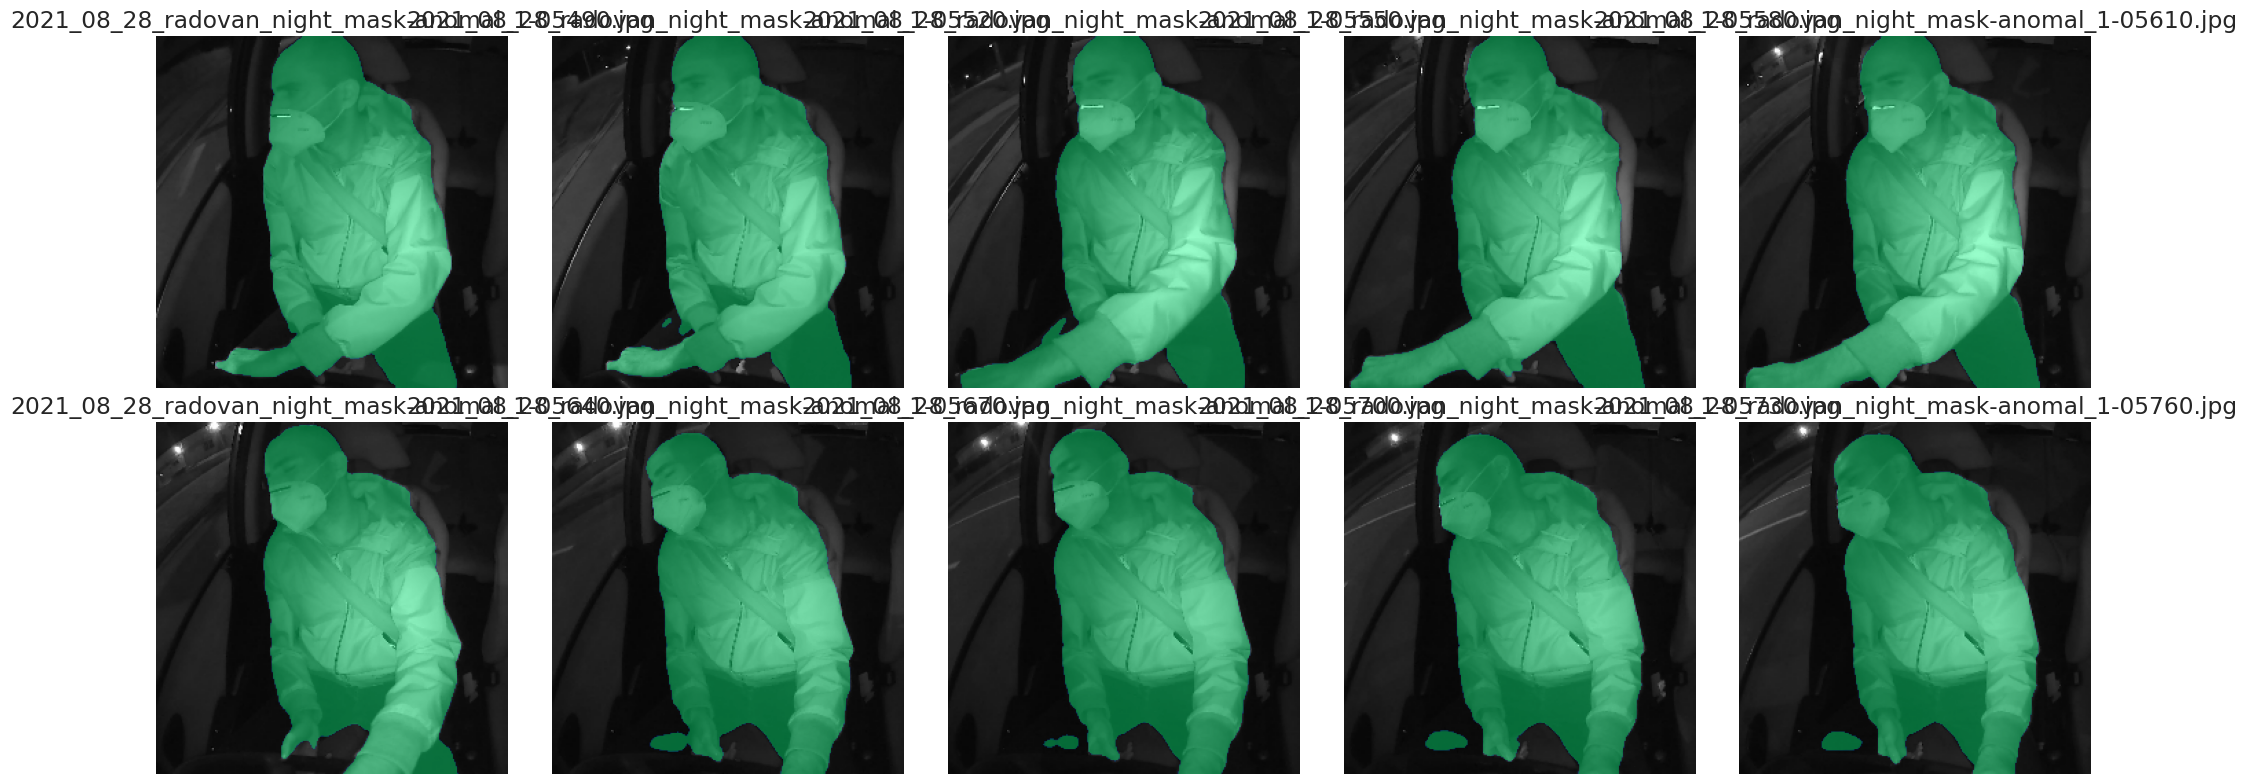

In [22]:
plot_predictions_compact(
    model_, test_dataloader, save_path=EXPERIMENT_DIR / PREDICTIONS_PNG_NAME, limit=10
)

In [ ]:
# plot_predictions(model_, test_dataloader)

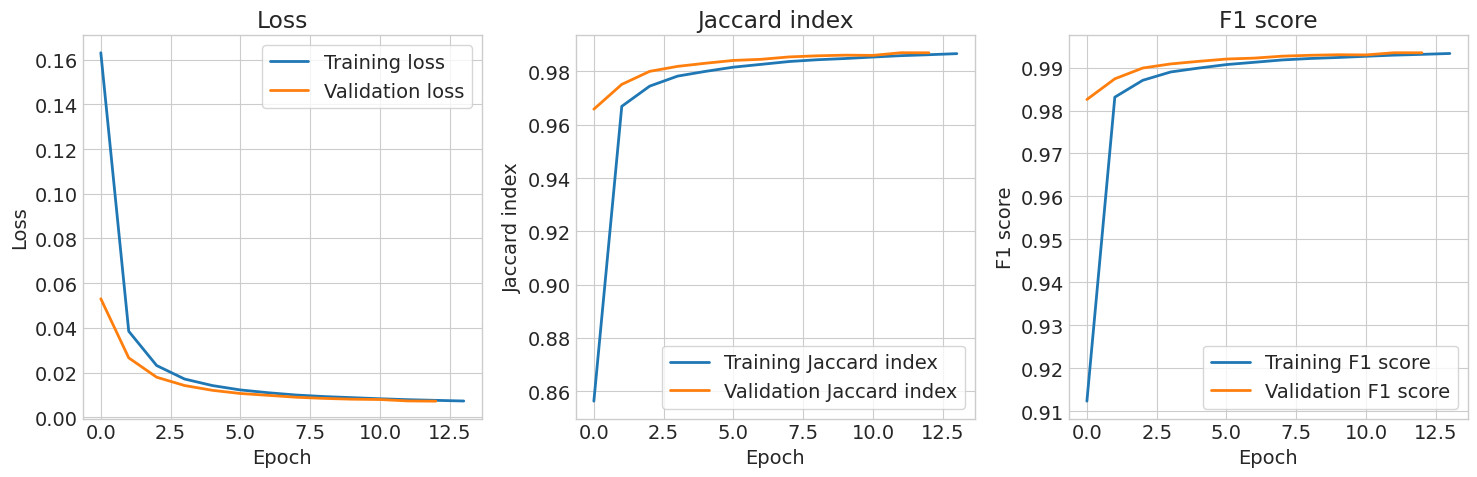

In [23]:
plot_learning_curves(
    EXPERIMENT_DIR / METRICS_CSV_NAME,
    save_path=EXPERIMENT_DIR / LEARNING_CURVES_PDF_NAME,
)

## Logging

In [24]:
# Save the transforms for experiment logging
albu.save(train_transforms, EXPERIMENT_DIR / TRAIN_TRANSFORMS_JSON_NAME)

In [25]:
def get_early_stopping_epoch() -> int | None:
    checkpoint = list(EXPERIMENT_DIR.glob('*.ckpt'))[0].stem
    pattern = r'epoch=(\d+)'
    match = re.search(pattern, checkpoint)
    if match:
        return int(match.group(1))
    else:
        return None

In [26]:
def log_dict_to_mlflow(dictionary: dict[str, float]) -> None:
    for k, v in dictionary.items():
        mlflow.log_metric(k, v)

In [27]:
with mlflow.start_run(run_name=f'{EXPERIMENT_NAME}') as run:
    try:
        mlflow.set_tag('Branch', get_current_branch())
        mlflow.set_tag('Commit ID', get_commit_id())
        mlflow.set_tag('Dataset', DATASET_NAME)
    except Exception as e:
        print(e)

    log_dict_to_mlflow(dict(valid_metrics))
    log_dict_to_mlflow(dict(test_metrics))

    mlflow.log_param('encoder', ENCODER)
    mlflow.log_param('decoder', DECODER)
    mlflow.log_param('batch_size', BATCH_SIZE)
    mlflow.log_param('max_epochs', MAX_EPOCHS)
    mlflow.log_param('early_stopping', get_early_stopping_epoch())
    mlflow.log_param('monitor', MONITOR)
    mlflow.log_param('patience', PATIENCE)
    mlflow.log_param('image_size', IMAGE_SIZE)
    mlflow.log_param('frozen_encoder', FREEZE_ENCODER)
    mlflow.log_param('encoder_weights', ENCODER_WEIGHTS)
    mlflow.log_param('learning_rate', LEARNING_RATE)
    mlflow.log_param('augmentation', AUGMENTATION)

    mlflow.log_artifact(str(EXPERIMENT_DIR / METRICS_CSV_NAME), MLFLOW_ARTIFACT_DIR)
    mlflow.log_artifact(
        str(EXPERIMENT_DIR / LEARNING_CURVES_PDF_NAME), MLFLOW_ARTIFACT_DIR
    )
    mlflow.log_artifact(str(EXPERIMENT_DIR / PREDICTIONS_PNG_NAME), MLFLOW_ARTIFACT_DIR)
    mlflow.log_artifact(
        str(EXPERIMENT_DIR / TRAIN_TRANSFORMS_JSON_NAME), MLFLOW_ARTIFACT_DIR
    )
    mlflow.log_artifact('train.ipynb', MLFLOW_ARTIFACT_DIR)

    # Models are versioned by default
    mlflow.pytorch.log_model(
        pytorch_model=model_,
        artifact_path='model',
        registered_model_name=f'pytorch-{EXPERIMENT_NAME}',
    )

Successfully registered model 'pytorch-2024-09-15-215831-unet-efficientnet-b0'.
2024/09/15 22:19:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pytorch-2024-09-15-215831-unet-efficientnet-b0, version 1
Created version '1' of model 'pytorch-2024-09-15-215831-unet-efficientnet-b0'.
2024/09/15 22:19:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/09/15 22:19:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 2024-09-15-215831-unet-efficientnet-b0 at: https://dagshub.com/matejfric/driver-state.mlflow/#/experiments/0/runs/11b04e75c48941d4a42a88f6ae589972.
2024/09/15 22:19:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/matejfric/driver-state.mlflow/#/experiments/0.
